<h1 align="center">Machine Learning for Bioinformatics</h1>
<h3 align="center">Freie Universität Berlin - SoS 2023</h3>
<h5 align="center">Exercise Notebook Week 04 - From Linear to Kernel Regression</h5>
<hr style="border:2px solid gray">

### Import python packages
---

In [1]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

---
# Assignment 1: From polynomial regression to kernel regression
---
The following defines a simple data set with 25 samples for testing polynomial regression:

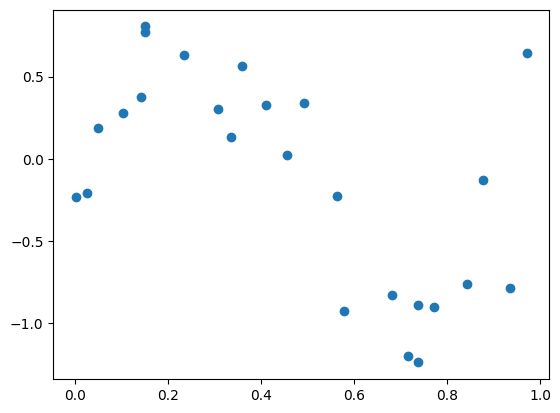

In [2]:
data = np.array([
    0.001399613, -0.23436656,
    0.971629779,  0.64689524,
    0.579119475, -0.92635765,
    0.335693937,  0.13000706,
    0.736736086, -0.89294863,
    0.492572335,  0.33854780,
    0.737133774, -1.24171910,
    0.563693769, -0.22523318,
    0.877603280, -0.12962722,
    0.141426545,  0.37632006,
    0.307203910,  0.30299077,
    0.024509308, -0.21162739,
    0.843665029, -0.76468719,
    0.771206067, -0.90455412,
    0.149670258,  0.77097952,
    0.359605608,  0.56466366,
    0.049612895,  0.18897607,
    0.409898906,  0.32531750,
    0.935457898, -0.78703491,
    0.149476207,  0.80585375,
    0.234315216,  0.62944986,
    0.455297119,  0.02353327,
    0.102696671,  0.27621694,
    0.715372314, -1.20379729,
    0.681745393, -0.83059624 ]).reshape(25,2)
y = data[:,1]
X = data[:,0:1]

plt.scatter(X[:,0], y)
plt.show()

---
# 1.1 Polynomial features
---
The function *compute_polynomial_features* takes as input a vector $x \in \mathbb{R}^n$ and returns a matrix $F$ of $p$ features, where column $k$ corresponds to $x^{k-1}$, $k = 1, 2, \dots, p$

In [15]:
def compute_polynomial_features(X, degree):
    # degree = p+1
    x = X if len(X.shape) == 1 else X[:,0]
    # Complete the implementation of this function
    return np.power(x.reshape(-1,1), np.arange(degree+1))

In [16]:
compute_polynomial_features(X, 3)

array([[1.00000000e+00, 1.39961300e-03, 1.95891655e-06, 2.74172507e-09],
       [1.00000000e+00, 9.71629779e-01, 9.44064427e-01, 9.17281111e-01],
       [1.00000000e+00, 5.79119475e-01, 3.35379366e-01, 1.94224723e-01],
       [1.00000000e+00, 3.35693937e-01, 1.12690419e-01, 3.78294905e-02],
       [1.00000000e+00, 7.36736086e-01, 5.42780060e-01, 3.99885657e-01],
       [1.00000000e+00, 4.92572335e-01, 2.42627505e-01, 1.19511597e-01],
       [1.00000000e+00, 7.37133774e-01, 5.43366201e-01, 4.00533578e-01],
       [1.00000000e+00, 5.63693769e-01, 3.17750665e-01, 1.79114070e-01],
       [1.00000000e+00, 8.77603280e-01, 7.70187517e-01, 6.75919091e-01],
       [1.00000000e+00, 1.41426545e-01, 2.00014676e-02, 2.82873846e-03],
       [1.00000000e+00, 3.07203910e-01, 9.43742423e-02, 2.89921362e-02],
       [1.00000000e+00, 2.45093080e-02, 6.00706179e-04, 1.47228927e-05],
       [1.00000000e+00, 8.43665029e-01, 7.11770681e-01, 6.00496032e-01],
       [1.00000000e+00, 7.71206067e-01, 5.94758798e

---
# 1.2 Polynomial regression
---

We estimate the parameters $\theta$ of our (polynomial) regression model using $\ell_2$-penalized ordinary least squares (ridge regression):
$$
    \hat{\theta} = \mathrm{argmin}_\theta \left\Vert y - F \theta \right\Vert_2^2 + \alpha \left\Vert \theta \right\Vert_2^2
$$
which has the following analytical solution
$$
    \hat{\theta} = (F^\top F + \alpha I)^{-1} F^\top y
$$
The class *PolynomialRegression* implements this estimator:

In [21]:
class PolynomialRegression:
    def __init__(self, degree=1, alpha=0.0):
        self.degree = degree
        self.theta  = None
        self.alpha  = alpha
    
    def fit(self, X, y):
        # Please use *np.linalg.pinv* to compute matrix inverses
        # compute the polynomial features
        X_poly = compute_polynomial_features(X, self.degree)
        # compute the theta parameters
        self.theta = np.linalg.pinv(X_poly.T.dot(X_poly) + self.alpha * np.eye(X_poly.shape[1])).dot(X_poly.T).dot(y)
        return self

    def predict(self, X):
        # Complete the implementation
        X_poly = compute_polynomial_features(X, self.degree)
        return X_poly.dot(self.theta)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"degree" : self.degree, "alpha" : self.alpha}

---
# 1.3 Performance of polynomial regression
---

The following shows a simple fit of a polynomial model on the entire data set:

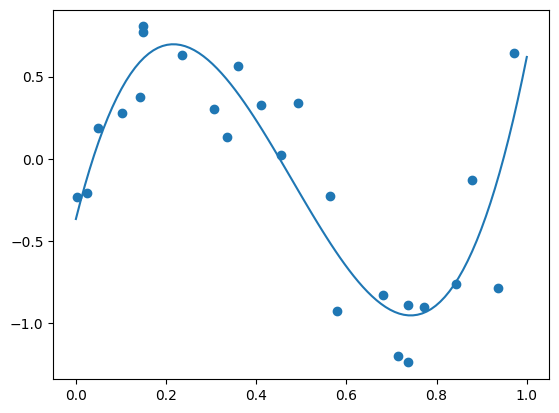

In [22]:
reg = PolynomialRegression(3, alpha=0)
reg.fit(X, y)

x_test = np.linspace(0,1,100)
plt.plot(x_test, reg.predict(x_test))
plt.scatter(X[:,0], y)
plt.show()

Now we test the performance of the polynomial regression model using *Leave One Out CV* (LOO-CV). We use $\alpha = 0.0$ and test all degrees from $1$ up to $10$. The result should show for each degree the average *mean squared error* (MSE):

Best parameters: {'degree': 3}
Best cross-validation score: 0.12


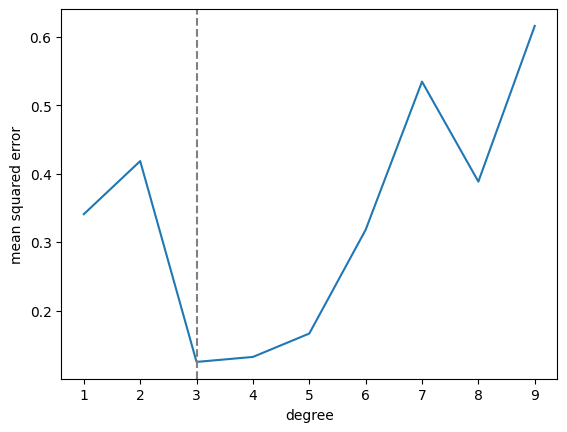

In [31]:
# Use GridSearchCV to implement LOO-CV parameter evaluation. Plot the result and draw a vertical line at the optimal parameters (degree).
model = PolynomialRegression()

param_grid = {'degree': np.arange(1, 10)}
loo = LeaveOneOut()
grid = GridSearchCV(model, param_grid, cv=loo, scoring='neg_mean_squared_error')
grid.fit(X, y)

print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(-grid.best_score_))

# Plot the result and draw a vertical line at the optimal parameters (degree).
plt.plot(param_grid['degree'], -grid.cv_results_['mean_test_score'])
plt.xlabel('degree')
plt.ylabel('mean squared error')
plt.axvline(grid.best_params_['degree'], linestyle='--', color='.5')
plt.show()


---
# 1.4 Polynomial kernel regression
---

The *KernelPolynomialRegression* class implements the corresponding kernel version of our polynomial regression model.

In [38]:
class KernelPolynomialRegression:
    def __init__(self, degree=1, alpha=0.0):
        self.degree = degree
        self.theta    = None
        self.alpha  = alpha 
        self.F      = None # Feature matrix
    
    def fit(self, X, y):
        # Please use *np.linalg.pinv* to compute matrix inverses
        n_samples = X.shape[0]
        # Compute the kernel matrix
        kernelMatrix = self.compute_kernel_matrix(X) 
        identity = np.eye(n_samples)
        # Compute the parameter vector
        self.theta = np.linalg.pinv(kernelMatrix + self.alpha * identity) @ y 


    def predict(self, X):
        K_star = self.compute_kernel_matrix(X, self.F)  # Compute the kernel matrix for test samples
        return np.dot(K_star, self.theta)  # Predict the output      

    def set_params(self, parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"degree" : self.degree, "alpha" : self.alpha}
    
    def compute_kernel_matrix(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        return (1 + np.dot(X1, X2.T)) ** self.degree

The folloging shows a comparison of the the polynomal regression and the kernel version:

In [41]:
reg1 = KernelPolynomialRegression(10, alpha=0.0)
reg1.fit(X, y)
reg2 = PolynomialRegression(10, alpha=0.0)
reg2.fit(X, y)

x_test = np.linspace(0,1,100)
plt.plot(x_test, reg1.predict(x_test), color='red')
plt.plot(x_test, reg2.predict(x_test))
plt.scatter(X[:,0], y)
plt.ylim(-2,2)
plt.show()

ValueError: shapes (100,100) and (25,) not aligned: 100 (dim 1) != 25 (dim 0)

---
# 1.5 Performance comparison of polynomial kernel regression
---

We compare the performance of the kernel regression model to standard polynomial regression using LOO-CV. We use $\alpha = 0.0$ and test all degrees from $1$ up to $20$. Plot for both methods and each degree the average *mean squared error* (MSE):

---
# 1.5 Performance comparison of polynomial kernel regression with penalty
---

We fix the maximum degree to 15 and now test several penalty strengths, i.e.
$$
    \alpha = 0.001, 0.005, 0.01, 0.02, 0.05, 0.1
$$
Plot the performance of both polynomial and polynomial kernel regression using LOO-CV and MSE as error measure.

---
# Assignment 2: Prediction of gene expression from promoter sequences
---
### Import data
---

For importing the gene expression data, please make sure that you have an up to date version of pandas installed. We used version *1.4.2* for preparing the data. If this conflicts with your python environment, you might try to use a separate *conda environment* for our excercises.

In [2]:
path_to_training_file = 'exercise-04-data/gene_expression_liver_featurized.pkl.gz'

with gzip.open(path_to_training_file, 'rb') as f:
    X_raw, y_raw = pickle.load(f)

# Reduce data size
X_raw = X_raw[0:5000]
y_raw = y_raw[0:5000]

---
### Outlier removal and normalization
---

In [3]:
y_threshold = 10000

X = StandardScaler().fit_transform(X_raw[y_raw < y_threshold])
y = np.log(1.0 + y_raw[y_raw < y_threshold])

---
### Histogram
---

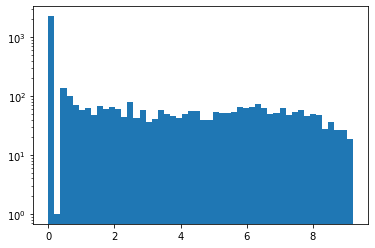

In [4]:
plt.hist(y, bins=50)
plt.yscale('log')
plt.show()

---
## 2.1 Performance of linear regression
---

As a first example, we evaluate the performance of a linear regression model. Please use *LinearRegression* from scikit-learn. We use the *KFold* class of scikit-learn to implement 5-fold CV with random shuffling of the data $(X, y)$ and a random state of 42 (in order to obtain comparable results). The final result should show the average $R^2$ over all 5 CV folds.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Assuming you have your data X and y

# Create the linear regression model
model = LinearRegression()

# Create a KFold object with 5 folds and random shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store R2 scores from each fold
r2_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the R2 score for this fold and store it
    r2_scores.append(r2_score(y_test, y_pred))

# Calculate the average R2 score over all folds
average_r2 = np.mean(r2_scores)

# Print the average R2 score
print("Average R2 score:", average_r2)


---
## 2.2 Performance of kernel regression
---

We now turn our attention to kernel regression and make use of the implementation in scikit-learn. We use the *KernelRidge* regressor in combination with the *rbf* kernel and keep $\gamma = 0.001$ fixed. The parameter $\alpha$ will be subject to optimization, for which we use *GridSearchCV* to test the following parameter values $\alpha = 0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3$. The training procedure of kernel regression is too expensive for a fully-fledged k-fold CV. Instead, we use *ShuffleSplit* with only two splits, a training size of $1000$ samples and a random state of 42.

In [ ]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.kernel_ridge import KernelRidge

# Assuming you have your data X and y

# Set the parameter values to test
param_values = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]

# Create the ShuffleSplit object with 2 splits, a training size of 1000 samples, and random state 42
shuffle_split = ShuffleSplit(n_splits=2, train_size=1000, random_state=42)

# Create the KernelRidge regressor with the rbf kernel and gamma=0.001 fixed
model = KernelRidge(kernel='rbf', gamma=0.001)

# Create the GridSearchCV object with the regressor, parameter grid, and scoring metric
grid_search = GridSearchCV(model, param_grid={'alpha': param_values}, scoring='r2', cv=shuffle_split)

# Fit the grid search on the data
grid_search.fit(X, y)

# Get the best parameter and best score from the grid search
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Print the best parameter and best score
print("Best alpha:", best_alpha)
print("Best R2 score:", best_score)
